<a href="https://colab.research.google.com/github/rlskoeser/shxco-missingdata-specreading/blob/main/missing-data/Sco_missing_borrowing_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Missing Borrowing Activity Data from Shakespeare and Company Project

This notebook explores and predicts missing data related to borrowing. It contains the code for figure 8 in our paper.

## Setup Libraries and Load S&Co Data

In [38]:
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import altair as alt
import sys
sys.path.append('..')

from utils.missing_data_processing import *

In [3]:
events_df, members_df, _, _  = load_initial_data()
events_df = preprocess_events_data(events_df)

## Identify borrows and subscriptions

The section filters event data to separate borrow and subscription events, and fills missing subscription volumes with a default value. It then associates borrow events with corresponding subscriptions based on member ID and event dates, and calculates the number of borrow events that occur during each subscription period. By associating borrow events with corresponding subscriptions, we can gain insights into user behavior during their subscription periods.

In [4]:
# Filter the events dataframe to include only events with complete start and end dates.
# Note: This step might exclude borrow events with no end date. Consider the impact of this exclusion on the analysis.
date_events = events_df[(events_df.start_date.str.len() > 9) & (events_df.end_date.str.len() > 9)].copy()

# Convert the 'start_date' and 'end_date' columns to datetime format. The 'errors' parameter is set to 'ignore' to skip any errors encountered during the conversion.
date_events['start_datetime'] = pd.to_datetime(date_events.start_date, format='%Y-%m-%d', errors='ignore')
date_events['end_datetime'] = pd.to_datetime(date_events.end_date, format='%Y-%m-%d', errors='ignore')

# Sort the dataframe by 'start_datetime'.
date_events = date_events.sort_values(by=['start_datetime'])

# Display the first two rows of the dataframe for a quick check.
date_events.head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_type,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime
671,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,...,Lending Library Card;Logbook,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,https://shakespeareandco.princeton.edu/members...,None,cahun,None,1919-11-17,1919-12-17
29915,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,...,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,flot-marcelle,None,1919-11-17,1920-11-17


In [5]:
# Filter the 'date_events' DataFrame to include only borrow events.
borrow_events = date_events[date_events.event_type == 'Borrow']

# Filter the 'date_events' DataFrame to include only subscription events with complete dates.
# The event types considered as subscription events are 'Subscription', 'Renewal', and 'Supplement'.
subscription_events = date_events[date_events.event_type.isin(['Subscription', 'Renewal', 'Supplement'])].copy()

# Some subscriptions (~377) do not have a documented subscription volume.
# For these subscriptions, assume a minimum subscription volume of 1.
subscription_events["subscription_volumes"] = subscription_events.subscription_volumes.apply(lambda x: x if pd.notna(x) else 1)

# Determine the date range for subscriptions.
# The earliest date is the start date of the first event in 'date_events'.
# The end date is the end date of the last subscription in 'subscription_events'.
earliest_date = date_events.start_datetime.iloc[0]
subs_end_date = subscription_events.end_datetime.max()

# For now, use the 'has_card' field to identify borrows that belong to subscriptions.
# Note: This is an approximation and may not be accurate.
member_subs = subscription_events.copy()
# Split the 'member_uris' field into 'first_member_uri' and 'second_member_uri' fields.
# This is done to handle joint accounts in subscriptions.
member_subs[['first_member_uri','second_member_uri']] = member_subs.member_uris.str.split(';', expand=True)
# Merge 'member_subs' with 'members_df' on 'first_member_uri' to get the 'has_card' field.
member_subs = pd.merge(left=member_subs, right=members_df, left_on="first_member_uri", right_on="uri")
# Filter 'member_subs' to include only subscriptions where 'has_card' is True.
member_subs = member_subs[member_subs.has_card]

### Associating Borrow Events with Corresponding Subscriptions

In [6]:
# Create a copy of the 'subscription_events' DataFrame to avoid SettingWithCopyWarning in pandas.
subscriptions_df = subscription_events.copy()

def count_borrows_during_subscription(subscription):
    """
    Count the number of borrow events that start during the subscription period.

    This function takes a subscription event and returns the number of borrow events that start during the subscription period.
    Note: Only the start date of the borrow event is considered. If a borrow event starts during the subscription period and ends after the subscription period, it is still counted.

    Args:
        subscription (pd.Series): A subscription event.

    Returns:
        int: The number of borrow events that start during the subscription period.
    """
    # Identify and count any borrow events that start during this subscription.
    # This is done by filtering 'borrow_events' to include only events where the member ID matches the subscription's member ID,
    # and the start date of the borrow event is within the subscription period.
    return len(borrow_events[(borrow_events.member_id == subscription.member_id) & 
              (subscription.start_date <= borrow_events.start_date) & (borrow_events.start_date <= subscription.end_date)])

# Apply the 'count_borrows_during_subscription' function to each subscription in 'subscriptions_df' to get the number of borrow events that start during each subscription period.
# Store the results in a new column 'documented_borrows'.
subscriptions_df['documented_borrows'] = subscriptions_df.apply(count_borrows_during_subscription, axis=1)

# Display the first few rows of 'subscriptions_df' for a quick check.
subscriptions_df.head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
671,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,...,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,https://shakespeareandco.princeton.edu/members...,None,cahun,None,1919-11-17,1919-12-17,3
29915,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,flot-marcelle,None,1919-11-17,1920-11-17,0


In [7]:
# check — example subscriptions with no borrows
subscriptions_df[subscriptions_df.documented_borrows == 0].head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
29915,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,flot-marcelle,None,1919-11-17,1920-11-17,0
29914,Subscription,1919-11-17,1920-02-17,https://shakespeareandco.princeton.edu/members...,Mrs. Worthing,"Worthing, Mrs.",12.0,NaN,3 months,92.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,worthing,None,1919-11-17,1920-02-17,0


In [8]:
# check — example subscriptions with at least one borrow
subscriptions_df[subscriptions_df.documented_borrows > 0].head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
671,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,...,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,https://shakespeareandco.princeton.edu/members...,None,cahun,None,1919-11-17,1919-12-17,3
672,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,Henri Regnier,"Regnier, Henri",4.0,5.6,1 month,30.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/c...,https://shakespeareandco.princeton.edu/members...,None,regnier,None,1919-11-18,1919-12-18,1


In [9]:
# Identify the subset of subscriptions with at least one borrow event
subs_with_borrows = subscriptions_df[subscriptions_df.documented_borrows > 0]

### Mapping Borrow Events to Their Corresponding Subscription Periods

In [10]:
# Create a copy of the 'borrow_events' DataFrame to avoid modifying the original DataFrame.
borrow_events_df = borrow_events.copy()

def is_borrow_within_subscription_period(borrow):
    """
    Determine if a borrow event falls within a subscription period.

    This function takes a borrow event and checks if it falls within a subscription period for the same member. It returns True if the borrow event falls within a subscription period, and False otherwise.

    Args:
        borrow (pd.Series): A borrow event.

    Returns:
        bool: True if the borrow event falls within a subscription period, False otherwise.
    """
    # Check if the borrow event falls within a subscription period for the same member.
    # This is done by filtering 'subscriptions_df' to include only subscriptions where the member ID matches the borrow event's member ID,
    # and the start date of the borrow event is within the subscription period.
    return bool(len(subscriptions_df[(subscriptions_df.member_id == borrow.member_id) & 
              (subscriptions_df.start_date <= borrow.start_date) &
              (subscriptions_df.end_date >= borrow.start_date)]))

# Apply the 'is_borrow_within_subscription_period' function to each borrow event in 'borrow_events_df' to determine if it falls within a subscription period.
# Store the results in a new column 'within_subscription'.
borrow_events_df['within_subscription'] = borrow_events_df.apply(is_borrow_within_subscription_period, axis=1)

In [11]:
# check to confirm
borrow_events_df[~borrow_events_df.within_subscription].head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,within_subscription
768,Borrow,1920-01-12,1920-01-22,https://shakespeareandco.princeton.edu/members...,Blanche Reverchon,"Reverchon, Blanche",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Blanche Reverchon Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7e...,https://shakespeareandco.princeton.edu/members...,None,reverchon,galsworthy-addresses-america-1919,1920-01-12,1920-01-22,False
779,Borrow,1920-01-22,1920-03-13,https://shakespeareandco.princeton.edu/members...,Blanche Reverchon,"Reverchon, Blanche",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Blanche Reverchon Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7e...,https://shakespeareandco.princeton.edu/members...,None,reverchon,dreiser-sister-carrie,1920-01-22,1920-03-13,False


In [12]:
borrows_within_subscriptions = borrow_events_df[borrow_events_df.within_subscription]

## Borrowed books and subscription volumes by day

In [15]:
# Initialize a one-day timedelta for incrementing the date.
one_day = timedelta(days=1)

# Initialize the start date as the earliest start date in 'date_events'.
day = date_events.start_datetime.iloc[0]

# Initialize lists to store the data for each date.
dates = []
books_out = []
borrow_events_perday = []
subscription_vols = []
card_subscription_vols = []
book_subscription_vols = []

# Iterate over each date until the end of the last subscription.
while day < subs_end_date:
    # Append the current date to 'dates'.
    dates.append(day)

    # Count the number of borrow events that span the current date and append the count to 'books_out'.
    books_out.append(len(borrows_within_subscriptions[(borrows_within_subscriptions.start_datetime <= day) & (borrows_within_subscriptions.end_datetime > day)]))

    # Sum the volumes of active subscriptions on the current date and append the sum to 'subscription_vols'.
    subscription_vols.append(subscription_events[(subscription_events.start_datetime <= day) & (day < subscription_events.end_datetime)].subscription_volumes.sum())

    # Sum the volumes of active subscriptions for members with extant cards on the current date and append the sum to 'card_subscription_vols'.
    card_subscription_vols.append(member_subs[(member_subs.start_datetime <= day) & (day < member_subs.end_datetime)].subscription_volumes.sum())

    # Sum the volumes of active subscriptions with at least one borrow event on the current date and append the sum to 'book_subscription_vols'.
    book_subscription_vols.append(subs_with_borrows[(subs_with_borrows.start_datetime <= day) & (day < subs_with_borrows.end_datetime)].subscription_volumes.sum())

    # Count the borrow events that started on the current date and append the count to 'borrow_events_perday'.
    borrow_events_perday.append(len(borrow_events[borrow_events.start_datetime == day]))

    # Increment the date by one day.
    day += one_day

# Create a DataFrame 'borrowing_df' to store the data for each date.
borrowing_df  = pd.DataFrame({
    'date': dates,
    'books_out': books_out,
    'borrow_event_count': borrow_events_perday,
    'subscription_volumes': subscription_vols,
    'card_subscription_volumes': card_subscription_vols,
    'book_subscription_volumes': book_subscription_vols
})

borrowing_df.head(2)

,date,books_out,borrow_event_count,subscription_volumes,card_subscription_volumes,book_subscription_volumes
0,1919-11-17,0,0,3.0,1.0,1.0
1,1919-11-18,3,3,9.0,4.0,4.0


In [16]:
# where do card member subs and book subs differ?
borrowing_df[borrowing_df.card_subscription_volumes != borrowing_df.book_subscription_volumes].head(2)

,date,books_out,borrow_event_count,subscription_volumes,card_subscription_volumes,book_subscription_volumes
5,1919-11-22,4,2,14.0,6.0,5.0
6,1919-11-23,4,0,14.0,6.0,5.0


In [17]:
# what is the ratio of subscriptions to borrow events?
borrowing_df['book_events_per_subscription_vol'] = borrowing_df.apply(lambda x: x.borrow_event_count / x.book_subscription_volumes, axis=1)
borrowing_df.head(2)

,date,books_out,borrow_event_count,subscription_volumes,card_subscription_volumes,book_subscription_volumes,book_events_per_subscription_vol
0,1919-11-17,0,0,3.0,1.0,1.0,0.00
1,1919-11-18,3,3,9.0,4.0,4.0,0.75


In [18]:
borrowing_df['book_events_per_subscription_vol'].describe()

count    8326.000000
mean        0.094945
std         0.142912
min         0.000000
25%         0.000000
50%         0.069767
75%         0.146341
max         6.000000
Name: book_events_per_subscription_vol, dtype: float64

In [19]:
# aggregate subscriptions by day so that we can get a weekly/monthly average of the _total_ subscription volumes

borrowing_daily = borrowing_df.groupby([pd.Grouper(key='date', freq='D')]) \
  .agg({'book_subscription_volumes':'sum',
        'borrow_event_count': 'sum', 'card_subscription_volumes':'sum', 
        'book_subscription_volumes': 'sum', 
        'subscription_volumes': 'sum'}).reset_index()
borrowing_daily.head(13)

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes
0,1919-11-17,1.0,0,1.0,3.0
1,1919-11-18,4.0,3,4.0,9.0
2,1919-11-19,5.0,2,5.0,10.0
3,1919-11-20,5.0,0,5.0,11.0
4,1919-11-21,5.0,0,5.0,13.0
5,1919-11-22,5.0,2,6.0,14.0
6,1919-11-23,5.0,0,6.0,14.0
7,1919-11-24,5.0,1,7.0,16.0
8,1919-11-25,6.0,1,8.0,17.0
9,1919-11-26,6.0,0,8.0,19.0


### Aggregate borrowed books and subscriptions by week

In [20]:
# Aggregate the daily borrowing data into weekly data.
# For each week, we calculate:
# - the maximum number of book subscription volumes ('book_subscription_volumes')
# - the total number of borrow events ('borrow_event_count')
# - the maximum number of card subscription volumes ('card_subscription_volumes')
# - the maximum number of subscription volumes ('subscription_volumes')
# The 'pd.Grouper' function is used to group the data by week.
borrowing_weekly = borrowing_daily.groupby([pd.Grouper(key='date', freq='W')]).agg({
    'book_subscription_volumes':'max',
    'borrow_event_count': 'sum', 
    'card_subscription_volumes':'max', 
    'subscription_volumes': 'max'
})

# Reset the index of the DataFrame to make 'date' a column again.
borrowing_weekly = borrowing_weekly.reset_index()

# Display the 'borrowing_weekly' DataFrame.
borrowing_weekly.head(2)

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes
0,1919-11-23,5.0,7,6.0,14.0
1,1919-11-30,7.0,5,9.0,27.0


In [21]:
borrowing_weekly.borrow_event_count.describe()

count    1190.000000
mean       16.490756
std        12.728959
min         0.000000
25%         8.000000
50%        13.000000
75%        23.000000
max        84.000000
Name: borrow_event_count, dtype: float64

In [22]:
borrowing_weekly['ratio'] = borrowing_weekly.apply(lambda row: row.borrow_event_count / row.book_subscription_volumes, axis=1)
borrowing_weekly.ratio.describe()

count    1190.000000
mean        0.642890
std         0.364388
min         0.000000
25%         0.428571
50%         0.636364
75%         0.833333
max         6.000000
Name: ratio, dtype: float64

### Visualizing Borrowing Activity Over Time

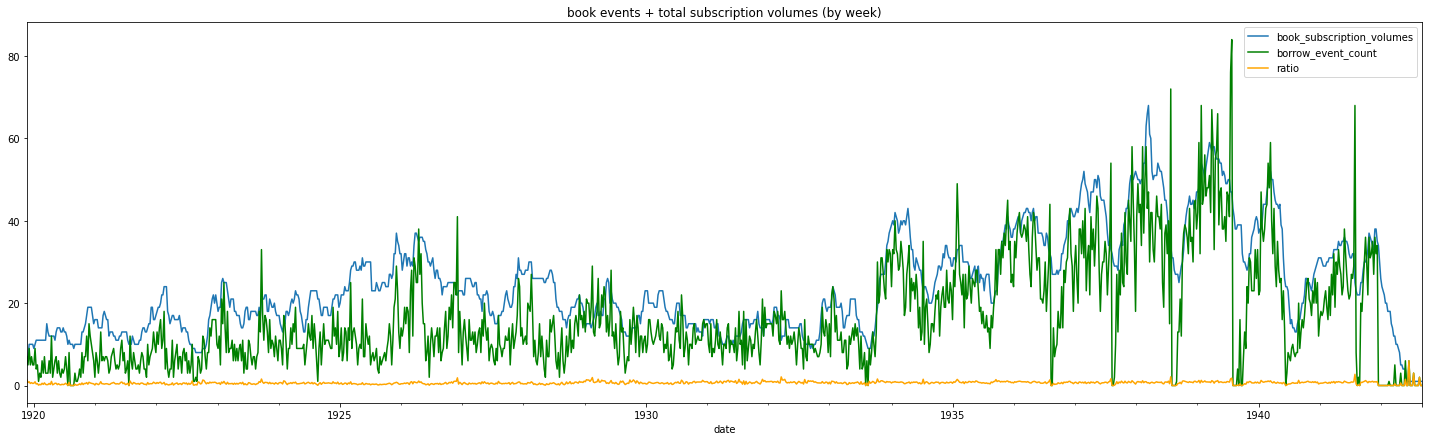

In [24]:
# Get the current axis so we can plot multiple series on the same axis.
ax = plt.gca()

# Plot the weekly book subscription volumes over time.
# The 'kind' parameter is set to 'line' to create a line plot.
# The 'x' and 'y' parameters specify the data to plot on the x-axis and y-axis.
# The 'ax' parameter is set to the current axis to plot on the same axis.
# The 'figsize' parameter sets the size of the figure.
# The 'title' parameter sets the title of the plot.
borrowing_weekly.plot(kind='line', x='date', y='book_subscription_volumes', ax=ax, figsize=(25,7), title='book events + total subscription volumes (by week)')

# Plot the weekly count of borrow events over time on the same axis.
# The 'color' parameter is set to 'green' to differentiate this line from the others.
borrowing_weekly.plot(kind='line', x='date', y='borrow_event_count', color='green', ax=ax)

# Plot the ratio of borrow events to book subscription volumes over time on the same axis.
# The 'color' parameter is set to 'orange' to differentiate this line from the others.
borrowing_weekly.plot(kind='line', x='date', y='ratio', color='orange', ax=ax)

# Display the plot.
plt.show()

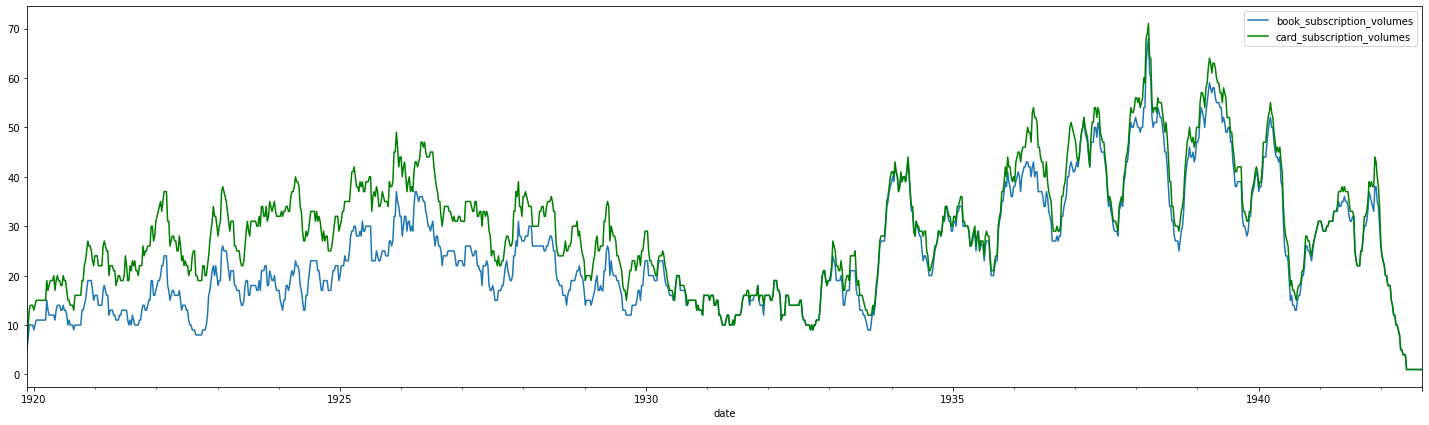

In [25]:
# Compare book subscription volumes with card subscription volumes over time to see how different they are.

# Get the current axis so we can plot multiple series on the same axis.
ax = plt.gca()

# Plot the weekly book subscription volumes over time.
# The 'kind' parameter is set to 'line' to create a line plot.
# The 'x' and 'y' parameters specify the data to plot on the x-axis and y-axis.
# The 'ax' parameter is set to the current axis to plot on the same axis.
# The 'figsize' parameter sets the size of the figure.
borrowing_weekly.plot(kind='line', x='date', y='book_subscription_volumes', ax=ax, figsize=(25,7))

# Plot the weekly card subscription volumes over time on the same axis.
# The 'color' parameter is set to 'green' to differentiate this line from the book subscription volumes.
borrowing_weekly.plot(kind='line', x='date', y='card_subscription_volumes', color='green', ax=ax)

# Display the plot.
plt.show()

In [26]:
# Aggregate the daily borrowing data into monthly data.
# For each month, we calculate:
# - the maximum number of book subscription volumes ('book_subscription_volumes')
# - the total number of borrow events ('borrow_event_count')
# The 'pd.Grouper' function is used to group the data by month.
borrowing_monthly = borrowing_daily.groupby([pd.Grouper(key='date', freq='MS')]).agg({
    'book_subscription_volumes':'max',
    'borrow_event_count': 'sum'
})

# Reset the index of the DataFrame to make 'date' a column again.
borrowing_monthly = borrowing_monthly.reset_index()

# Display the first two rows of 'borrowing_monthly' for a quick check.
borrowing_monthly.head(2)

,date,book_subscription_volumes,borrow_event_count
0,1919-11-01,7.0,12
1,1919-12-01,10.0,30


In [27]:
borrowing_monthly.borrow_event_count.describe()

count    275.000000
mean      71.360000
std       50.290302
min        0.000000
25%       38.500000
50%       53.000000
75%       99.500000
max      251.000000
Name: borrow_event_count, dtype: float64

In [28]:
borrowing_monthly['ratio'] = borrowing_monthly.apply(lambda row: row.borrow_event_count / row.book_subscription_volumes, axis=1)
borrowing_monthly.ratio.describe()

count    275.000000
mean       2.600836
std        0.985389
min        0.000000
25%        1.935417
50%        2.625000
75%        3.264231
max        6.000000
Name: ratio, dtype: float64

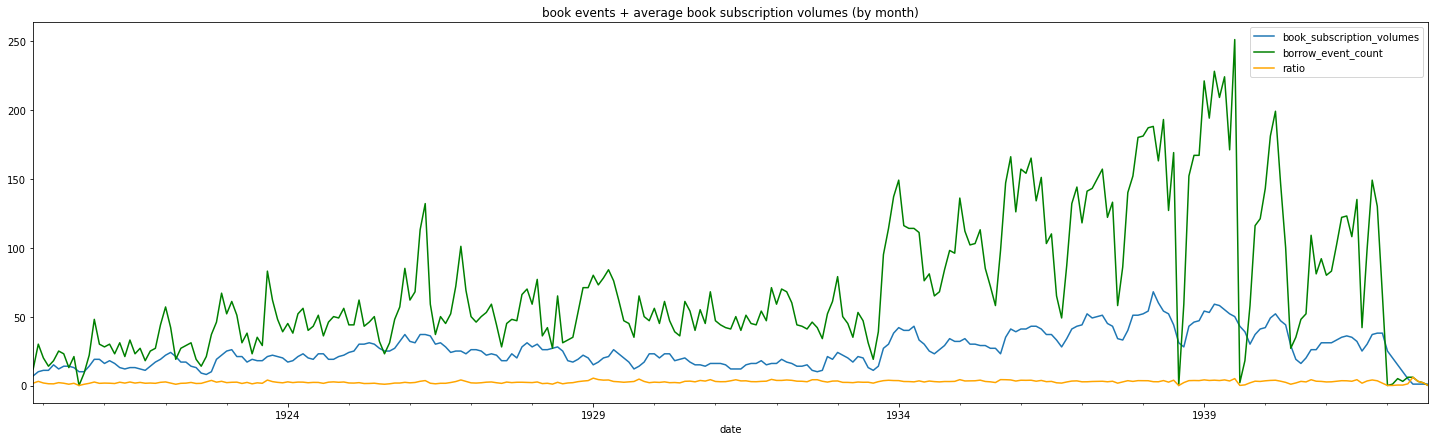

In [29]:
# Get the current axis so we can plot multiple series on the same axis.
ax = plt.gca()

# Plot the monthly book subscription volumes over time.
borrowing_monthly.plot(kind='line', x='date', y='book_subscription_volumes', ax=ax, figsize=(25,7), title='book events + average book subscription volumes (by month)')

# Plot the monthly count of borrow events over time on the same axis.
# The 'color' parameter is set to 'green' to differentiate this line from the others.
borrowing_monthly.plot(kind='line', x='date', y='borrow_event_count', color='green', ax=ax)

# Plot the ratio of borrow events to book subscription volumes over time on the same axis.
# The 'color' parameter is set to 'orange' to differentiate this line from the others.
borrowing_monthly.plot(kind='line', x='date', y='ratio', color='orange', ax=ax)

# Display the plot.
plt.show()

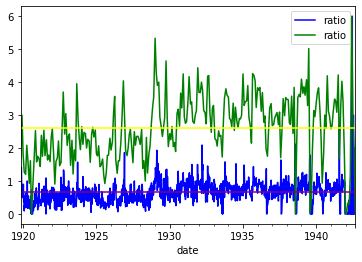

In [30]:
# if we plot just the ratio, how stable is it?
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='ratio', color='blue', ax=ax)
borrowing_monthly.plot(kind='line',x='date',y='ratio', color='green', ax=ax)

# monthly ratio average
#plt.axhline(y=2.858, color='yellow', linestyle='-')  # 2.8 is ratio when we use average subscription
plt.axhline(y=2.6, color='yellow', linestyle='-')  # 2.6 is ratio when we use max # subscriptions


# weekly ratio average
plt.axhline(y=0.663, color='purple', linestyle='-')  # weekly ratio doesn't change noticeably when we switch from mean to max

plt.show()

In [31]:
# ok, now apply our ratio to the non-book subscription volumes
borrowing_weekly['non_book_subs_vols'] = borrowing_weekly.apply(lambda row: row.subscription_volumes - row.book_subscription_volumes, axis=1)
borrowing_weekly.head(2)

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols
0,1919-11-23,5.0,7,6.0,14.0,1.400000,9.0
1,1919-11-30,7.0,5,9.0,27.0,0.714286,20.0


In [32]:
borrow_events_per_subsvol = borrowing_weekly.ratio.mean()
print(f'Average borrow events per book subscription volume: {borrow_events_per_subsvol}')

Average borrow events per book subscription volume: 0.6428904216675599


In [33]:
# Filter the 'borrowing_weekly' DataFrame to include only rows where the 'ratio' is between 0.6 and 0.65.
# The '&' operator is used to combine the conditions.
# The result is a subset of 'borrowing_weekly' where the 'ratio' is within the specified range.
# This could be useful for identifying weeks where the ratio of borrow events to book subscription volumes is within a certain range.
filtered_borrowing_weekly = borrowing_weekly[(borrowing_weekly.ratio >= 0.6) & (borrowing_weekly.ratio <= 0.65)]
filtered_borrowing_weekly.head(5)

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols
15,1920-03-07,11.0,7,15.0,82.0,0.636364,71.0
47,1920-10-17,13.0,8,19.0,80.0,0.615385,67.0
54,1920-12-05,19.0,12,26.0,126.0,0.631579,107.0
73,1921-04-17,13.0,8,22.0,147.0,0.615385,134.0
83,1921-06-26,13.0,8,20.0,133.0,0.615385,120.0


In [34]:
# Calculate the estimated number of borrow events for each week.
# This is done by multiplying the number of non-book subscription volumes ('non_book_subs_vols') by the average number of borrow events per subscription volume ('borrow_events_per_subsvol').
# The result is stored in a new column 'estimated_borrow_events'.
borrowing_weekly['estimated_borrow_events'] = borrowing_weekly.non_book_subs_vols.apply(lambda x: x * borrow_events_per_subsvol)

# Display the first two rows of 'borrowing_weekly' for a quick check.
borrowing_weekly.head(2)

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols,estimated_borrow_events
0,1919-11-23,5.0,7,6.0,14.0,1.400000,9.0,5.786014
1,1919-11-30,7.0,5,9.0,27.0,0.714286,20.0,12.857808


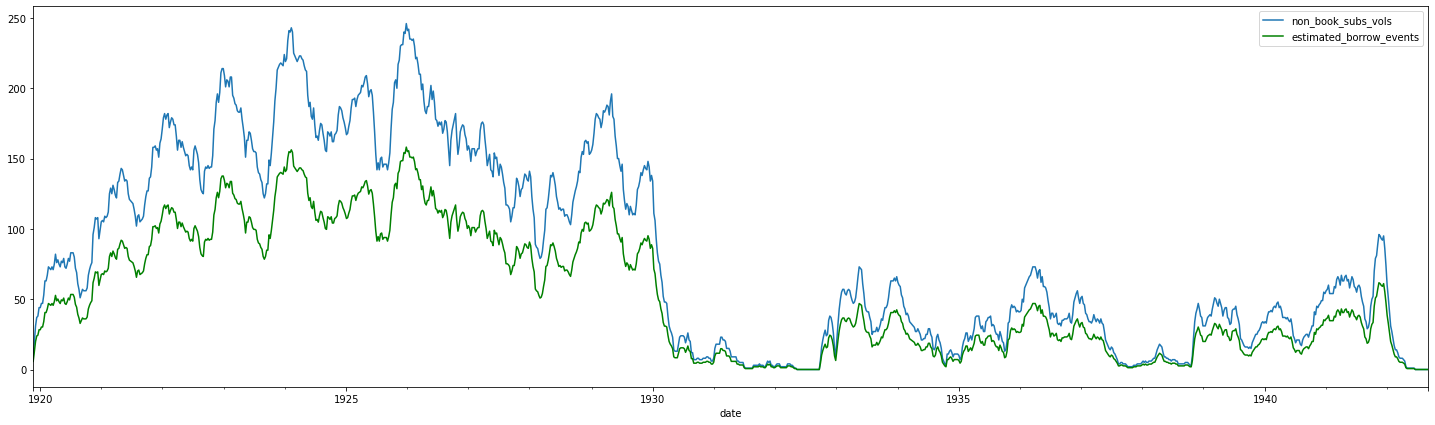

In [36]:
# Get the current axis so we can plot multiple series on the same axis.
ax = plt.gca()

# Plot the weekly non-book subscription volumes over time.
borrowing_weekly.plot(kind='line', x='date', y='non_book_subs_vols', ax=ax, figsize=(25,7))

# Plot the estimated weekly borrow events over time on the same axis.
# The 'color' parameter is set to 'green' to differentiate this line from the non-book subscription volumes.
borrowing_weekly.plot(kind='line', x='date', y='estimated_borrow_events', color='green', ax=ax)

# Display the plot.
plt.show()

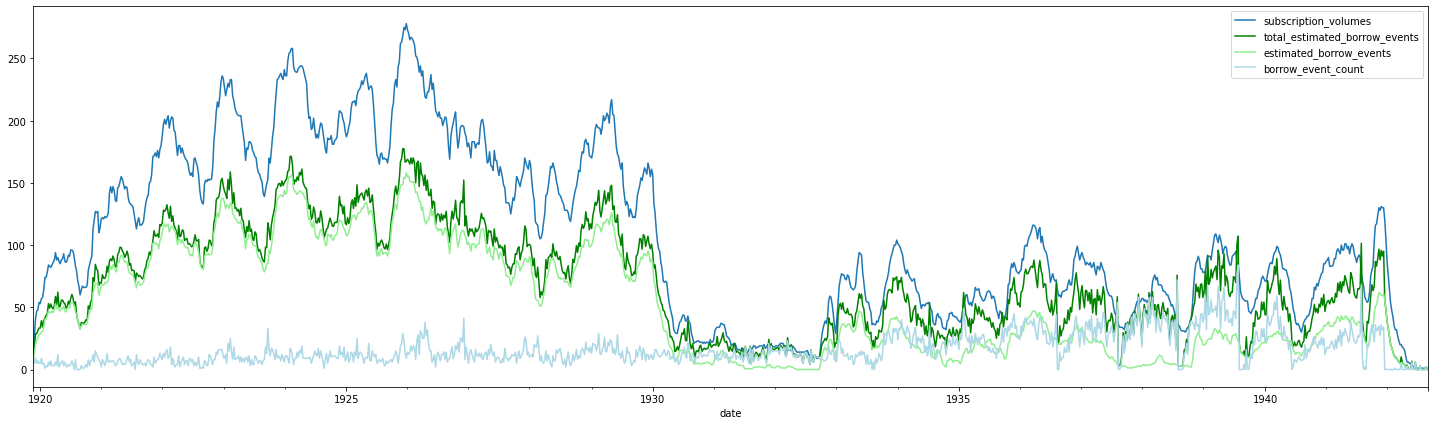

In [37]:
# Get the current axis so we can plot multiple series on the same axis.
ax = plt.gca()

# Calculate the total estimated borrow events for each week.
# This is done by adding the estimated borrow events ('estimated_borrow_events') to the actual borrow event count ('borrow_event_count').
# The result is stored in a new column 'total_estimated_borrow_events'.
borrowing_weekly['total_estimated_borrow_events'] = borrowing_weekly.apply(lambda row: row.estimated_borrow_events + row.borrow_event_count, axis=1)

# Plot the weekly subscription volumes over time.
borrowing_weekly.plot(kind='line', x='date', y='subscription_volumes', ax=ax, figsize=(25,7))

# Plot the total estimated weekly borrow events over time on the same axis.
# The 'color' parameter is set to 'green' to differentiate this line from the subscription volumes.
borrowing_weekly.plot(kind='line', x='date', y='total_estimated_borrow_events', color='green', ax=ax)

# Plot the estimated weekly borrow events over time on the same axis.
# The 'color' parameter is set to 'lightgreen' to differentiate this line from the others.
borrowing_weekly.plot(kind='line', x='date', y='estimated_borrow_events', color='lightgreen', ax=ax)

# Plot the actual weekly borrow event count over time on the same axis.
# The 'color' parameter is set to 'lightblue' to differentiate this line from the others.
borrowing_weekly.plot(kind='line', x='date', y='borrow_event_count', color='lightblue', ax=ax)

# Display the plot.
plt.show()

In [39]:
# Prepare the 'borrowing_weekly' DataFrame for plotting with Altair by flattening it and adding a 'type' column to differentiate the series.

# Create a DataFrame 'alt_subs_vols' with the date and total subscription volumes for each week.
# The 'rename' function is used to rename 'subscription_volumes' to 'total'.
# The 'type' column is added to indicate that these are subscription volumes.
alt_subs_vols = borrowing_weekly.rename(columns={"subscription_volumes": "total"})[["date", "total"]]
alt_subs_vols["type"] = "Subscription volumes"

# Create a DataFrame 'alt_borrow_count' with the date and borrow event count for each week.
# The 'rename' function is used to rename 'borrow_event_count' to 'total'.
# The 'type' column is added to indicate that these are borrow event counts.
alt_borrow_count = borrowing_weekly.rename(columns={"borrow_event_count": "total"})[["date", "total"]]
alt_borrow_count["type"] = "Borrow event count"

# Create a DataFrame 'alt_est_borrow_count' with the date and estimated borrow events for each week.
# The 'rename' function is used to rename 'estimated_borrow_events' to 'total'.
# The 'type' column is added to indicate that these are estimated borrow events.
alt_est_borrow_count = borrowing_weekly.rename(columns={"estimated_borrow_events": "total"})[["date", "total"]]
alt_est_borrow_count["type"] = "Estimated borrow events"

# Create a DataFrame 'alt_totalest_borrow_count' with the date and total estimated borrow events for each week.
# The 'rename' function is used to rename 'total_estimated_borrow_events' to 'total'.
# The 'type' column is added to indicate that these are total estimated borrow events.
alt_totalest_borrow_count = borrowing_weekly.rename(columns={"total_estimated_borrow_events": "total"})[["date", "total"]]
alt_totalest_borrow_count["type"] = "Total estimated borrow events"

# Concatenate the four DataFrames into a single DataFrame 'alt_borrowing_weekly'.
# This DataFrame can be used to create a plot with Altair where each series is color-coded based on the 'type' column.
alt_borrowing_weekly = pd.concat([alt_subs_vols, alt_borrow_count, alt_est_borrow_count, alt_totalest_borrow_count])

# Display the first two rows of 'alt_borrowing_weekly' for a quick check.
alt_borrowing_weekly.head(2)

,date,total,type
0,1919-11-23,14.0,Subscription volumes
1,1919-11-30,27.0,Subscription volumes


### Figure - Borrowing activity, subscription volumes, and estimated borrowing activity.

In [40]:
# This chart visualizes the total subscription volumes, borrow event count, estimated borrow events, and total estimated borrow events over time via Altair.

chart = alt.Chart(alt_borrowing_weekly).encode(
    alt.X('date:T', axis=alt.Axis(title='Duration of the Lending Library')),
).properties(
    width=1200,
    # height=chart_height
)

estimated_borrowing = chart.mark_line(strokeWidth=1).encode(
    alt.Y("total", axis=alt.Axis(title='Number of volumes')),
    color=alt.Color("type", title="", scale=alt.Scale(domain=["Subscription volumes", "Borrow event count", "Estimated borrow events", "Total estimated borrow events"],
                                                      range=["#5276A7", "green", "lightgreen", "lightblue"]))
)
estimated_borrowing


alt.Chart(...)

In [41]:
# figure 8
# estimated_borrowing.save("fig8-estimated_borrowing.json")

<Axes: xlabel='date'>

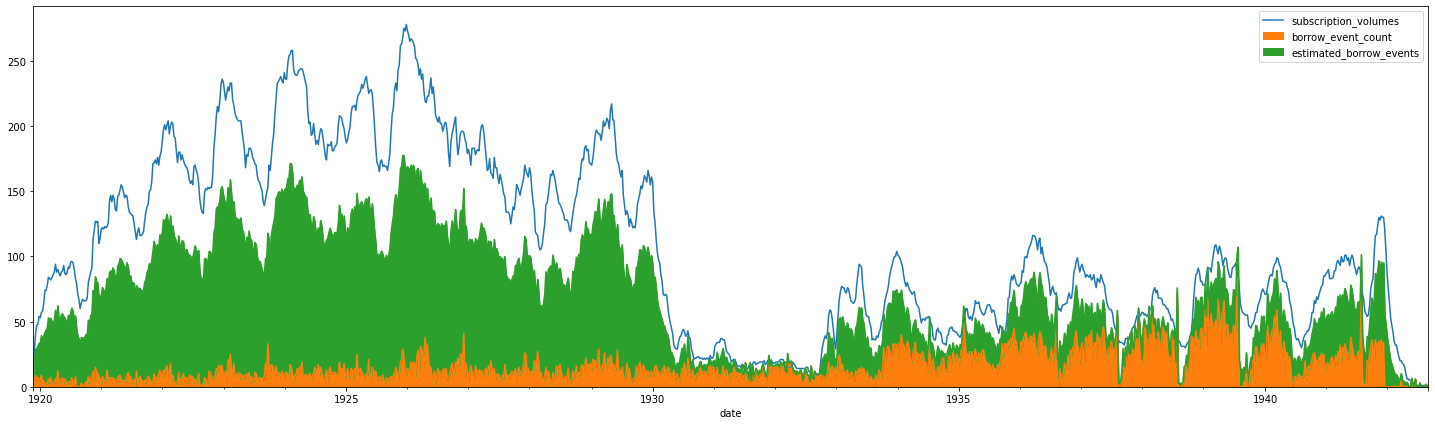

In [42]:
ax = plt.gca()
# total subscriptoin volumes
borrowing_weekly.plot(kind='line',x='date',y='subscription_volumes',ax=ax, figsize=(25,7))
# stacked area chart of actual borrows and estimated missing 
borrowing_weekly[['date', 'borrow_event_count', 'estimated_borrow_events']].plot.area(x='date', stacked=True, ax=ax)
# line plot the total over the stack (not really helpful)
# borrowing_weekly.plot(kind='line',x='date',y='total_estimated_borrow_events', color='yellow', ax=ax)




In [43]:
# Calculate the total number of estimated missing borrow events based on known subscriptions.
# This can give us an idea of how many borrow events might be missing from our data.
est_total_missing_borrows = borrowing_weekly.estimated_borrow_events.sum()
print(f"Estimated total missing borrow events: {est_total_missing_borrows}")

# Calculate the number of borrow events that were used to generate our estimate.
# This can help us understand the size of the sample that our estimate is based on.
total_borrows_used_to_estimate =  borrows_within_subscriptions.shape[0]
print(f"Number of borrow events used to generate estimate: {total_borrows_used_to_estimate}")

Estimated total missing borrow events: 63330.49254804966
Number of borrow events used to generate estimate: 17292


In [44]:
all_borrows = events_df[events_df.event_type == 'Borrow']
all_borrows.head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,item_year,item_notes,source_type,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id
2,Borrow,1922,1922-08-23,https://shakespeareandco.princeton.edu/members...,Mr. Rhys,"Rhys, Mr.",NaN,NaN,NaN,NaN,...,1902.0,NaN,Lending Library Card,"Sylvia Beach, Rhys Lending Library Card, Box 4...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/67...,https://shakespeareandco.princeton.edu/members...,None,rhys,conrad-typhoon
8,Borrow,1923,1923-11-07,https://shakespeareandco.princeton.edu/members...,Eyre de Lanux / Mrs. Pierre de Lanux,"de Lanux, Eyre",NaN,NaN,NaN,NaN,...,1919.0,NaN,Lending Library Card,"Sylvia Beach, Eyre de Lanux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c5...,https://shakespeareandco.princeton.edu/members...,None,lanux-eyre-de,woolf-night-day


## Borrow estimates for specific periods


### Feb 28 1931 — 75 books out

Selected because of noted on the handwritten tally of the library books

In [45]:
# Filter the 'borrowing_weekly' DataFrame to include only rows where the date is in February 1931.
filtered_borrowing_weekly = borrowing_weekly[(borrowing_weekly.date >= pd.to_datetime('1931-02-01')) & (borrowing_weekly.date <= pd.to_datetime('1931-02-28'))]
filtered_borrowing_weekly


,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols,estimated_borrow_events,total_estimated_borrow_events
584,1931-02-01,16.0,7,16.0,34.0,0.437500,18.0,11.572028,18.572028
585,1931-02-08,16.0,9,16.0,34.0,0.562500,18.0,11.572028,20.572028
586,1931-02-15,14.0,8,14.0,37.0,0.571429,23.0,14.786480,22.786480
587,1931-02-22,14.0,11,14.0,37.0,0.785714,23.0,14.786480,25.786480


oh, but her tally is books out, not book events; can we compare that?

In [46]:
subscriptions_df.head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
671,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,...,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,https://shakespeareandco.princeton.edu/members...,None,cahun,None,1919-11-17,1919-12-17,3
29915,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,flot-marcelle,None,1919-11-17,1920-11-17,0


In [47]:
# Set the date for which we want to tally active subscriptions.
tally_date = pd.to_datetime(date(1931, 2, 28))

# Filter the 'subscriptions_df' DataFrame to include only rows where the subscription is active on 'tally_date'.
# A subscription is considered active if its start date is on or before 'tally_date' and its end date is on or after 'tally_date'.
# This can help us understand how many subscriptions were active on a specific date.
tally_subs = subscriptions_df[(subscriptions_df.start_datetime <= tally_date) & (subscriptions_df.end_datetime >= tally_date)]

# Display the first two rows of 'tally_subs' for a quick check.
tally_subs.head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
11153,Renewal,1930-03-05,1931-03-05,https://shakespeareandco.princeton.edu/members...,Helene Brémond,"Brémond, Helene",240.0,NaN,1 year,365.0,...,"Sylvia Beach, Helene Bremond Lending Library C...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/cb...,https://shakespeareandco.princeton.edu/members...,None,bremond-helene,None,1930-03-05,1931-03-05,29
11234,Renewal,1930-04-06,1931-04-06,https://shakespeareandco.princeton.edu/members...,Renée Antoine-May,"Antoine-May, Renée",240.0,NaN,1 year,365.0,...,"Sylvia Beach, Renée Antoine-May Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7c...,https://shakespeareandco.princeton.edu/members...,None,antoine-may,None,1930-04-06,1931-04-06,30


In [49]:
# Print the number of active subscriptions on the tally date.
print(f"Number of active subscriptions on {tally_date.strftime('%Y-%m-%d')}: {tally_subs.shape[0]}")

# Print the number of active members on the tally date.
print(f"Number of active members on {tally_date.strftime('%Y-%m-%d')}: {len(tally_subs.member_id.unique())}")

# how many subscription volumes?

tally_subs.subscription_volumes.describe()

Number of active subscriptions on 1931-02-28: 31
Number of active members on 1931-02-28: 30


count    31.000000
mean      1.161290
std       0.454369
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: subscription_volumes, dtype: float64

In [50]:
# Print the total subscription volumes for active subscriptions on the tally date.
print(f"Total subscription volumes for active subscriptions on {tally_date.strftime('%Y-%m-%d')}: {tally_subs.subscription_volumes.sum()}")

# how many subscriptions with volume = 1 ?
print(f"Number of subscriptions with volume = 1: {tally_subs[tally_subs.subscription_volumes == 1].shape[0]}")
tally_subs.subscription_volumes.value_counts()

Total subscription volumes for active subscriptions on 1931-02-28: 36.0
Number of subscriptions with volume = 1: 27


1.0    27
2.0     3
3.0     1
Name: subscription_volumes, dtype: int64

In [51]:
# which members had subscriptions with volume > 1 ?
tally_subs[tally_subs.subscription_volumes > 1][['event_type', 'start_date', 'end_date', 'member_names', 'subscription_volumes']]

,event_type,start_date,end_date,member_names,subscription_volumes
11369,Renewal,1930-06-23,1931-06-23,Mr. O'Conor,2.0
11670,Renewal,1930-11-01,1931-11-01,Fernand Colens,2.0
11753,Renewal,1930-12-09,1931-03-09,Dolly Wilde / Miss Dorothy Wilde,3.0
33610,Renewal,1931-02-14,1931-05-14,Tolstoy,2.0


In [52]:
# how many borrows do we have for that date?
tally_borrows = borrow_events_df[(borrow_events_df.start_datetime <= tally_date) & (borrow_events_df.end_datetime >= tally_date)]
tally_borrows.head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,within_subscription
2652,Borrow,1922-12-30,1932-05-02,https://shakespeareandco.princeton.edu/members...,Jacques Porel,"Porel, Jacques",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Jacques Porel Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7f...,https://shakespeareandco.princeton.edu/members...,None,porel,hardy-trumpet-major,1922-12-30,1932-05-02,True
10818,Borrow,1929-10-26,1931-11-14,https://shakespeareandco.princeton.edu/members...,Anatole Rivoallan,"Rivoallan, Anatole",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Rivoallan Lending Library Card, ...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif-cloud.princeton.edu/iiif/2/e0%2F1...,https://shakespeareandco.princeton.edu/members...,None,rivoallan-anatole,deirdre,1929-10-26,1931-11-14,True


In [53]:
# how many books out?
tally_borrows.shape[0]

32

In [54]:
# how many members?
len(tally_borrows.member_id.unique())

18

In [56]:
75/36

2.0833333333333335

### Percentage of borrowing from early period

In [55]:
# first logbook gap is January 01 1928

first_gap_start = pd.to_datetime(date(1928, 1, 1))

pre_first_gap_borrowing = borrowing_weekly[borrowing_weekly.date < first_gap_start]
pre_first_gap_borrowing.head(2)

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols,estimated_borrow_events,total_estimated_borrow_events
0,1919-11-23,5.0,7,6.0,14.0,1.400000,9.0,5.786014,12.786014
1,1919-11-30,7.0,5,9.0,27.0,0.714286,20.0,12.857808,17.857808


In [56]:
# Calculate the total estimated borrow events before the first gap.
# This can give us an idea of how many borrow events we would expect based on the subscriptions.
pregap_est_total = pre_first_gap_borrowing.total_estimated_borrow_events.sum()
print(f"Total estimated borrow events before the first gap: {pregap_est_total}")

# Calculate the total known borrow events before the first gap.
# This can help us understand how many borrow events were actually recorded.
pregap_known_total = pre_first_gap_borrowing.borrow_event_count.sum()
print(f"Total known borrow events before the first gap: {pregap_known_total}")

# Calculate the ratio of known borrow events to estimated borrow events.
# This can help us understand what proportion of the estimated borrow events were actually recorded.
ratio = pregap_known_total / pregap_est_total
print(f"Ratio of known borrow events to estimated borrow events: {ratio}")

# Convert the ratio to a percentage for easier interpretation.
percentage = ratio * 100
print(f"Percentage of estimated borrow events that were actually recorded: {percentage}%")

Total estimated borrow events before the first gap: 46024.66714941317
Total known borrow events before the first gap: 4159
Ratio of known borrow events to estimated borrow events: 0.09036458615764326
Percentage of estimated borrow events that were actually recorded: 9.036458615764326%


### Percentage of borrowing in the 1930s between gaps

In [57]:
# Define the start and end dates for the period in the 1930s between gaps.
# This period is from September 25, 1932 to January 1, 1937.
# The 'pd.to_datetime' function is used to convert the dates to datetime objects.
mid_gap_start = pd.to_datetime(date(1932, 9, 25))
mid_gap_end =  pd.to_datetime(date(1937, 1, 1))

# Filter the 'borrowing_weekly' DataFrame to include only rows where the date is within the defined period.
# This can help us analyze borrowing activity during this specific time period.
mid_gap_borrowing = borrowing_weekly[(borrowing_weekly.date > mid_gap_start) & (borrowing_weekly.date < mid_gap_end)]

# Display the 'mid_gap_borrowing' DataFrame for a quick check.
mid_gap_borrowing.head(2)

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols,estimated_borrow_events,total_estimated_borrow_events
671,1932-10-02,10.0,8,10.0,17.0,0.8,7.0,4.500233,12.500233
672,1932-10-09,10.0,9,10.0,26.0,0.9,16.0,10.286247,19.286247


In [58]:
# what is the estimated borrowing vs actual?

mid_gap_borrowing_est_total = mid_gap_borrowing.total_estimated_borrow_events.sum()

print(f"Estimated total borrow events during the mid-gap period: {mid_gap_borrowing_est_total}")

Estimated total borrow events during the mid-gap period: 10111.2744170707


In [59]:
# borrows with any date, to improve our reporting by period

all_borrows = events_df[events_df.event_type == 'Borrow']
all_borrows.head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,item_year,item_notes,source_type,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id
2,Borrow,1922,1922-08-23,https://shakespeareandco.princeton.edu/members...,Mr. Rhys,"Rhys, Mr.",NaN,NaN,NaN,NaN,...,1902.0,NaN,Lending Library Card,"Sylvia Beach, Rhys Lending Library Card, Box 4...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/67...,https://shakespeareandco.princeton.edu/members...,None,rhys,conrad-typhoon
8,Borrow,1923,1923-11-07,https://shakespeareandco.princeton.edu/members...,Eyre de Lanux / Mrs. Pierre de Lanux,"de Lanux, Eyre",NaN,NaN,NaN,NaN,...,1919.0,NaN,Lending Library Card,"Sylvia Beach, Eyre de Lanux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c5...,https://shakespeareandco.princeton.edu/members...,None,lanux-eyre-de,woolf-night-day


In [60]:
# The best date is defined as the longest string between the start date and end date.
# If one of the dates is missing (NaN), the other date is returned.
# If both dates are the same length, the end date is returned.
def get_best_date(row):
  # Calculate the length of the start date string, or 0 if it's NaN.
  start_date_len = len(row.start_date) if pd.notna(row.start_date) else 0
  # Calculate the length of the end date string, or 0 if it's NaN.
  end_date_len = len(row.end_date) if pd.notna(row.end_date) else 0

  # Return the start date if it's longer, otherwise return the end date.
  if start_date_len > end_date_len:
    return row.start_date
  else:
    return row.end_date

# Apply the 'get_best_date' function to each row in 'all_borrows'.
all_borrows['date'] = all_borrows.apply(get_best_date, axis=1)

# Display the start date, end date, and best date for the first few rows for a quick check.
all_borrows[['start_date', 'end_date', 'date']].head(2)

,start_date,end_date,date
2,1922,1922-08-23,1922-08-23
8,1923,1923-11-07,1923-11-07


In [61]:
# how many are still null?
print(f"Number of borrow events with missing dates: {all_borrows[all_borrows.date.isna()].shape[0]}")

Number of borrow events with missing dates: 6


In [62]:
# convert to datetime for comparison/filtering
all_borrows['dt'] = pd.to_datetime(all_borrows.date, errors='coerce')
all_borrows[['start_date', 'end_date', 'date', 'dt']].head(2)

,start_date,end_date,date,dt
2,1922,1922-08-23,1922-08-23,1922-08-23
8,1923,1923-11-07,1923-11-07,1923-11-07


In [63]:
# This function can be used to compare the estimated borrowing events with the actual borrowing events. This can help us understand how accurate our estimates are and how much data might be missing.
def borrowing_estimate_by_date(borrowing_weekly, start_date=None, end_date=None):
  # Copy the 'borrowing_weekly' and 'all_borrows' DataFrames to avoid modifying the original data.
  borrowing_chunk = borrowing_weekly.copy()
  period_borrows = all_borrows.copy()
  
  # If a start date is provided, filter the data to include only rows where the date is after the start date.
  if start_date:
    borrowing_chunk = borrowing_chunk[borrowing_chunk.date > start_date]
    period_borrows = period_borrows[period_borrows.dt > start_date]
  # If an end date is provided, filter the data to include only rows where the date is before the end date.
  if end_date:
    borrowing_chunk = borrowing_chunk[borrowing_chunk.date < end_date]
    period_borrows = period_borrows[period_borrows.dt < end_date]

  # Calculate the total estimated borrow events for the period.
  est_total = round(borrowing_chunk.total_estimated_borrow_events.sum())
  # Calculate the total known borrow events for the period.
  known_total = borrowing_chunk.borrow_event_count.sum()  
  # Calculate the total number of borrow events with any date for the period.
  total_any_borrows = period_borrows.shape[0]

  # Calculate the percentage of estimated borrow events that are known.
  percent_total = total_any_borrows / est_total * 100

  # Print the results.
  print(f"""Estimated borrowing between {start_date or ''} — {end_date or ''}:
  estimated total borrowing events: {est_total}
  known borrowing events (with full dates): {known_total}
  known borrowing events (with any dates): {total_any_borrows}
  surviving percent: {percent_total:.2f}
  """)

In [64]:
# Before the first gap
borrowing_estimate_by_date(borrowing_weekly, end_date=first_gap_start)

Estimated borrowing between  — 1928-01-01 00:00:00:
  estimated total borrowing events: 46025
  known borrowing events (with full dates): 4159
  known borrowing events (with any dates): 4459
  surviving percent: 9.69
  


In [65]:
# between logbook gaps in the 1930s

mid_gap_start = pd.to_datetime(date(1932, 9, 25))
mid_gap_end =  pd.to_datetime(date(1937, 1, 1))

borrowing_estimate_by_date(borrowing_weekly, mid_gap_start, mid_gap_end)


Estimated borrowing between 1932-09-25 00:00:00 — 1937-01-01 00:00:00:
  estimated total borrowing events: 10111
  known borrowing events (with full dates): 4810
  known borrowing events (with any dates): 5003
  surviving percent: 49.48
  


In [66]:
# after the last logbook gap
# 	August 29 1939 to September 12 1939 (14 days)

last_gap_end = pd.to_datetime(date(1939, 9, 12))

borrowing_estimate_by_date(borrowing_weekly, last_gap_end)

Estimated borrowing between 1939-09-12 00:00:00 — :
  estimated total borrowing events: 6503
  known borrowing events (with full dates): 2790
  known borrowing events (with any dates): 3436
  surviving percent: 52.84
  


### All borrows, official borrows

In [67]:
# Extract the year from the start date of each borrow event in 'all_borrows'.
# If the start date is NaN, None is returned.
# The result is stored in a new column 'year'.
all_borrows['year'] = all_borrows.start_date.apply(lambda x: x.split('-')[0] if pd.notna(x) else None)

# Display the unique years in the 'year' column for a quick check.
all_borrows.year.unique()

array(['1922', '1923', '1924', '1926', '1929', '1931', '1934', '1936',
       '1937', '1938', '1940', '1942', '1944', '1946', '1948', '1952',
       '1955', '1956', '1960', '1920', '1921', '1927', '1928', '1932',
       '1935', None, '1939', '1943', '1945', '1947', '1954', '1961', '',
       '1919', '1925', '1930', '1933', '1941', '1949', '1950', '1951',
       '1953', '1957', '1958', '1962'], dtype=object)

In [68]:
official_borrows = all_borrows[all_borrows.year < "1942"]
official_borrows.head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,date,dt,year
2,Borrow,1922,1922-08-23,https://shakespeareandco.princeton.edu/members...,Mr. Rhys,"Rhys, Mr.",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Rhys Lending Library Card, Box 4...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/67...,https://shakespeareandco.princeton.edu/members...,None,rhys,conrad-typhoon,1922-08-23,1922-08-23,1922
8,Borrow,1923,1923-11-07,https://shakespeareandco.princeton.edu/members...,Eyre de Lanux / Mrs. Pierre de Lanux,"de Lanux, Eyre",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Eyre de Lanux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c5...,https://shakespeareandco.princeton.edu/members...,None,lanux-eyre-de,woolf-night-day,1923-11-07,1923-11-07,1923


### Report on excluded events

In [71]:
# Calculate the total number of borrow events in 'events_df'.
total_borrows = events_df[events_df.event_type == 'Borrow'].shape[0]
print(f"Total number of borrow events: {total_borrows}")

# Calculate the total number of official borrow events.
total_official_borrows = official_borrows.shape[0]
print(f"Total number of official borrow events: {total_official_borrows}")

# Calculate the difference between the total number of borrow events and the total number of official borrow events. This can help us understand how many borrow events are not officially recorded.
difference = total_borrows - total_official_borrows
print(f"Difference between total and official borrow events: {difference}")

# Calculate the ratio of official borrow events to total borrow events. This can help us understand what proportion of the borrow events are officially recorded.
ratio = total_official_borrows / total_borrows
print(f"Ratio of official borrow events to total borrow events: {ratio}")

# what about other book activity?
book_events = events_df[events_df.item_uri.notna()]
total_book_events = book_events.shape[0]
print(f"Total number of book events: {total_book_events}")

# Calculate the ratio of official borrow events to total book events. This can help us understand what proportion of the book events are official borrows.
ratio = total_official_borrows / total_book_events
print(f"Ratio of official borrow events to total book events: {ratio}")

# Calculate the total official borrows minus the total borrows used to estimate.
# This can help us understand how many official borrows were used to generate our estimate.
total_borrows_used_to_estimate = total_official_borrows - total_borrows_used_to_estimate
print(f"Number of official borrow events used to generate estimate: {total_borrows_used_to_estimate}")

# Calculate estimated total based on subscriptions
est_total = est_total_missing_borrows + total_borrows_used_to_estimate
print(f"Estimated total borrow events based on subscriptions: {est_total}")

# Calculate the ratio of official borrow events to the estimated total.
# This can help us understand what proportion of the estimated borrow events are officially recorded.
ratio = total_official_borrows / est_total
print(f"Ratio of official borrow events to estimated total: {ratio}")


Total number of borrow events: 21059
Total number of official borrow events: 20597
Difference between total and official borrow events: 462
Ratio of official borrow events to total borrow events: 0.9780616363550027
Total number of book events: 22484
Ratio of official borrow events to total book events: 0.9160736523750223
Number of official borrow events used to generate estimate: 17292
Estimated total borrow events based on subscriptions: 80622.49254804966
Ratio of official borrow events to estimated total: 0.2554746119728875
